## Importing Essential Libraries

In [7]:
# core packages
import numpy as np
import pandas as pd

# image packages
import rasterio as rio
from PIL import Image
import cv2

# visualization packages
import matplotlib.pyplot as plt

## Loading Data

In [4]:
maize_data_path = "../data/raw/yield_maize.tif"
soybean_data_path = "../data/raw/yield_soybean.tif"
defor_img_path = "../data/raw/10S60W.tif"

# Loading maize data
with rio.open(maize_data_path) as maize_src:
    maize_data = maize_src.read()
maize_data = np.squeeze(maize_data)

# Loading deforestation data
with rio.open(defor_img_path) as defor_src:
    defor_data = defor_src.read()
defor_data = np.squeeze(defor_data)

## Data Segmentation

In [5]:
def get_lat_long(data, src):
    # index array
    lat_index = np.arange(0, data.shape[0])
    long_index = np.arange(0, data.shape[1])
    
    # meshgrid
    long_grid, lat_grid = np.meshgrid(long_index, lat_index)
    
    # flattened grids
    lat_grid_flat = lat_grid.flatten()
    long_grid_flat = long_grid.flatten()
    
    # getting long and lat
    A = src.transform
    long, lat = rio.transform.xy(A, lat_grid_flat, long_grid_flat)
    
    # reshaping to shape of original data
    lat = np.array(lat).reshape(data.shape)
    long = np.array(long).reshape(data.shape)
    
    return lat, long

def segment_coords(data, lat, long, target_coords = (0, 0), border = 0, length = 10):
    # latitude/longitude variables
    lat_max = target_coords[0]
    lat_min = lat_max - length
    long_min = target_coords[1]
    long_max = long_min + length
    
    # length variables
    xlen = data.shape[1]
    ylen = data.shape[0]
    
    # find xmin and xmax
    xmin, xmax = None, None
    for x in range(xlen):
        if long[0, x] > long_min:
            xmin = x if xmin == None else xmin
        if long[0, xlen - x - 1] < long_max:
            xmax = xlen - x - 1 if xmax == None else xmax
            
    # find ymin and ymax
    ymin, ymax = None, None
    for y in range(ylen):
        if lat[ylen - y - 1, 0] > lat_min:
            ymin = ylen - y - 1 if ymin == None else ymin
        if lat[y, 0] < lat_max:
            ymax = y if ymax == None else ymax
            
    # index data from top-bottom, left-right
    return data[ymax:ymin + border, xmin:xmax + border]

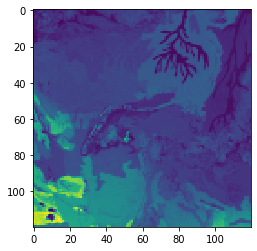

In [6]:
# Segmenting Maize Data 10S60W
target_coords = (-10, -60)
lat, long = get_lat_long(maize_data, maize_src)

maize_data_seg = segment_coords(maize_data, lat, long, target_coords, border = 1, length = 10)
plt.imshow(maize_data_seg)
plt.show()

# Gridding

In [10]:
CELLS_PER_EDGE = 50

## Gridding Using OpenCV Inter Area
https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html#resize

In [13]:
opencv_inter_area = cv2.resize(maize_data_seg, dsize=(CELLS_PER_EDGE, CELLS_PER_EDGE), interpolation = cv2.INTER_AREA)
opencv_inter_area[0,:20]


array([ 526,  807,  881,  945,  758,  855,  740,  987, 1251, 1005,  629,
        593,  396,  293,  564,  962, 1090, 1194, 1136, 1146], dtype=int16)

## Gridding Using OpenCV Inter Nearest
https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html#resize

In [14]:
opencv_inter_nearest = cv2.resize(maize_data_seg, dsize=(CELLS_PER_EDGE, CELLS_PER_EDGE), interpolation = cv2.INTER_NEAREST)
opencv_inter_nearest[0,:20]


array([ 461,  439, 1037, 1037,  769,  611,  786,  824, 1012, 1087,  793,
        389, 1004,  356,  284, 1127, 1056, 1219, 1055, 1215], dtype=int16)

## Gridding Using OpenCV Inter Linear
https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html#resize

In [15]:
opencv_inter_linear = cv2.resize(maize_data_seg, dsize=(CELLS_PER_EDGE, CELLS_PER_EDGE), interpolation = cv2.INTER_NEAREST)
opencv_inter_linear[0,:20]


array([ 461,  439, 1037, 1037,  769,  611,  786,  824, 1012, 1087,  793,
        389, 1004,  356,  284, 1127, 1056, 1219, 1055, 1215], dtype=int16)

## Gridding Using Pillow

In [25]:
pillow_img = Image.fromarray(maize_data_seg)
wpercent = (CELLS_PER_EDGE/float(pillow_img.size[0]))
hsize = int((float(pillow_img.size[1])*float(wpercent)))
pillow_grid = pillow_img.resize((CELLS_PER_EDGE,hsize), Image.ANTIALIAS)
np.array(pillow_grid)[0,:20]

array([ 507,  803,  945,  955,  769,  817,  717,  990, 1294, 1080,  588,
        526,  392,  190,  501,  943, 1124, 1212, 1147, 1133], dtype=int32)